# B-splineデモ 02

Noshita, Koji <noshita@morphometrics.jp>

できるだけシンプルなB-spline fittingによるcurve fragmentの後処理のデモンストレーション

切れ込みがあるもの，セレーションのあるものへの適用

## 方針

* [make_lsq_spline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.make_lsq_spline.html)を利用する
* 周期性は仮定しない
* （曲線上の位置を示す）パラメータへは微小ノイズを与えて同じ値が含まれないようにするハックをおこなう

In [1]:
import glob, pickle

import numpy as np
import scipy as sp
import pandas as pd

import open3d as o3d

from scipy.interpolate import make_lsq_spline, make_smoothing_spline

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def cvt_polar(x,y):
    """Convert to polar coordinate system
    x, y -> r, theta
    """
    r = np.sqrt(x**2+y**2)
    theta = np.sign(y)*np.arccos(x/np.sqrt(x**2+y**2))
    return r, theta

def generate_knots(start, end, n_interval, d):
    """Generate knot vector
    Parameters
    ==============
    start: float
    end: float
        start and end of knots
    n_interval: int
        number of interval
    d: int
        degree of B-spline
    
    Returns
    ==============
    knots: array, shape(n_interval+2*dim + 1)
        knot vector
    
    """
    step = (end-start)/n_interval
    knots_ = [i for i in np.arange(start, end+step, step)]
    knots_p = [knots_[0] for i in range(d)]
    knots_a = [knots_[-1] for i in range(d)]
    
    knots = np.array(knots_p + knots_ + knots_a)
    return knots

## データ読み込み・確認

In [143]:
# FILE_PATH = "../data/Bspline_202311/fix_45_maple_supported_curves.pickle"
i = 2
g = "upper"
name = "kannyou_opt_curves_{}_{}".format(g, i)
FILE_PATH = "data/supported_curve/kannyou_opt_curves_{}.pkl".format(g)

def zero_length_removal(l):
    return [i for i in l if len(i) != 0]


with open(FILE_PATH, "rb") as f:
    curve_fragments = pickle.load(f)
    temp_curves = [zero_length_removal(curves) for curves in curve_fragments if len(curves) != 0]
    curve_fragments_list = []
    for j in range(len(temp_curves)):
        curve_fragments = [curve for curves in temp_curves[j] for i, curve in enumerate(curves) if i%300 == 0]
        curve_fragments_list.append(curve_fragments)


In [144]:
curve_fragments = curve_fragments_list[i]

In [145]:
coord_3d = np.array(curve_fragments)

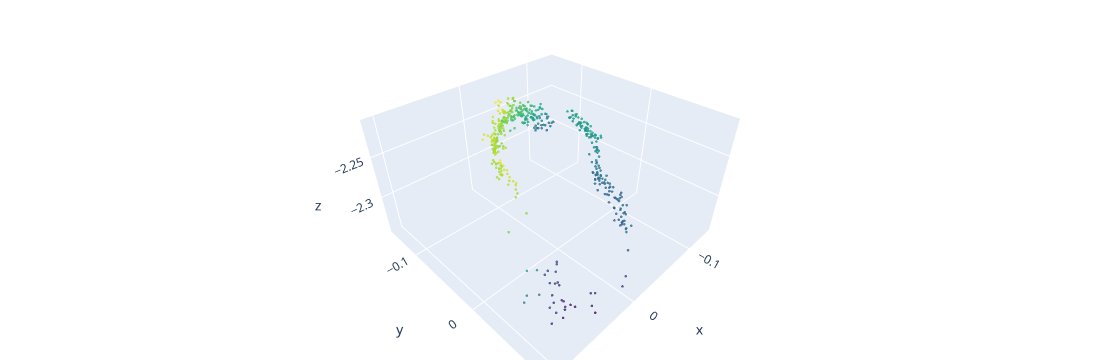

In [146]:
x,y,z = coord_3d[0:-1:100].T

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        color=z,                
        colorscale='Viridis',   
        opacity=0.8
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), 
    scene={"aspectmode":"data"}
)

## データ前処理

In [147]:
pca = PCA(n_components=3)
coord_2d = pca.fit_transform(coord_3d)
coord_2d = np.array([coord_2d[:,0], coord_2d[:,1]]).T

In [148]:
coord_2d.shape

(46328, 2)

In [149]:
#x_temp, y_temp = coord_3d[:,0], coord_3d[:,1]+2
#coord_2d = np.array([x_temp, y_temp]).T

<Axes: >

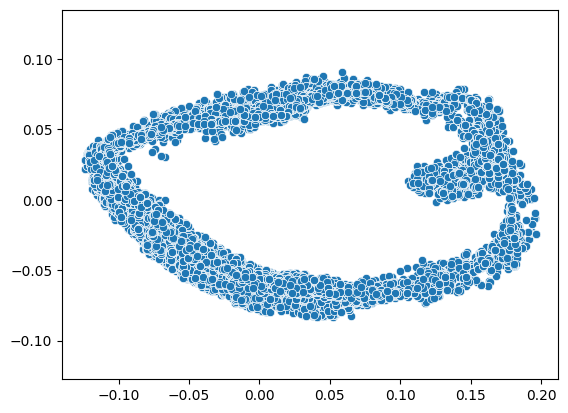

In [150]:
fig, ax = plt.subplots(1, 1)
ax.axis('equal')
sns.scatterplot(x=coord_2d[:,0], y=coord_2d[:,1], ax=ax)

In [151]:
r, theta = cvt_polar(coord_2d[:,0], coord_2d[:,1])

# thetaは-Pi/2から3Pi/2までとする場合
# 開始，終了点の曲率を低くするためのハック
# theta = np.array([t+2*np.pi if t < -np.pi/2 else t for t in theta])

<Axes: >

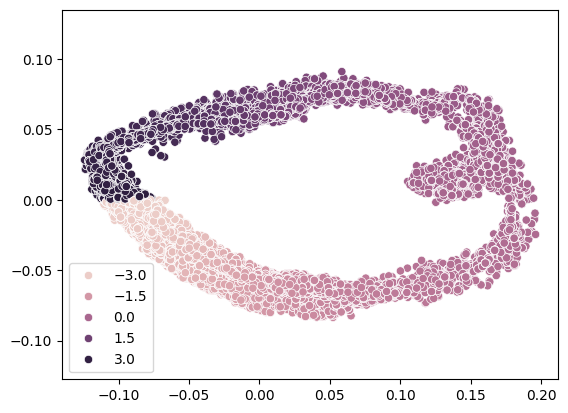

In [152]:
fig, ax = plt.subplots(1, 1)
ax.axis('equal')
sns.scatterplot(x=coord_2d[:,0], y=coord_2d[:,1], hue=theta, ax=ax)

## B-spline fitting 閉曲線版推定

In [153]:
from scipy.optimize import curve_fit, least_squares, minimize
from scipy.interpolate import BSpline

In [154]:
# def generate_knots_circular_bspline(start, end, n_interval, d):
    
#     step = (end-start)/n_interval
#     knots_ = [i for i in np.arange(start, end+step, step)]
#     knots_p = [knots_[i+len(knots_)-2] - (knots_[-1] - knots_[0]) for i in range(1-d, 1)]
#     knots_a = [knots_[i-len(knots_)]+ (knots_[-1]-knots_[0]) for i in range(len(knots_)+1,len(knots_)+d+2)]
    
#     knots = knots_p + knots_ + knots_a
    
#     return np.array(knots)

def generate_knots_circular_bspline(start, end, n_interval, d):
    
    step = (end-start)/n_interval
    knots_ = [i for i in np.arange(start, end, step)]
    knots_p = [knots_[i+len(knots_)-2] - (knots_[-1] - knots_[0]) for i in range(1-d, 1)]
    knots_a = [knots_[i-len(knots_)]+ (knots_[-1]-knots_[0]) for i in range(len(knots_)+1,len(knots_)+d+2)]
    
    knots = knots_p + knots_ + knots_a
    
    return np.array(knots)

In [155]:
degree = 3
n_interval = 32
knots = generate_knots_circular_bspline(-np.pi, np.pi, n_interval, degree)
print(len(knots), knots)

# def bspline_wrapper(theta, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19):
#     bspline = BSpline(knots, 
#                       [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, 0], 
#                       degree, extrapolate="periodic")
#     return bspline(theta)

# def bspline_wrapper(theta, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20):
#     bspline = BSpline(knots, 
#                       [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20], 
#                       degree, extrapolate="periodic")
#     return bspline(theta)
# def bspline_wrapper(theta, 
#                     c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, 
#                     c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, 
#                     c21, c22, c23, c24, c25, c26, c27, c28, c29, c30,
#                     c31, c32, c33, c34, c35, c36, c37, c38, c39
#                    ):
#     bspline = BSpline(knots, 
#                       [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, 
#                     c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, 
#                     c21, c22, c23, c24, c25, c26, c27, c28, c29, c30,
#                     c31, c32, c33, c34, c35, c36, c37, c38, c39], 
#                       degree, extrapolate="periodic")
#     return bspline(theta)

def generate_bspline_wrapper(knots, degree):
    str_def = """
def bspline_wrapper(theta, {c}):
    bspline = BSpline({knots}, [{c}], {degree}, extrapolate="periodic")
    return bspline(theta)
"""
    
    n_c = len(knots)
    knots_str = np.array2string(knots, precision=10^4, max_line_width=np.inf,separator=",")
    c_str = ", ".join(["c"+str(i) for i in range(n_c)])
    exec(str_def.format(c=c_str,  knots = knots_str, degree=degree), globals())
    
    return bspline_wrapper

bspline_wrapper = generate_bspline_wrapper(knots, degree)
bspline_wrapper

39 [-3.73064128e+00 -3.53429174e+00 -3.33794219e+00 -3.14159265e+00
 -2.94524311e+00 -2.74889357e+00 -2.55254403e+00 -2.35619449e+00
 -2.15984495e+00 -1.96349541e+00 -1.76714587e+00 -1.57079633e+00
 -1.37444679e+00 -1.17809725e+00 -9.81747704e-01 -7.85398163e-01
 -5.89048623e-01 -3.92699082e-01 -1.96349541e-01  3.55271368e-15
  1.96349541e-01  3.92699082e-01  5.89048623e-01  7.85398163e-01
  9.81747704e-01  1.17809725e+00  1.37444679e+00  1.57079633e+00
  1.76714587e+00  1.96349541e+00  2.15984495e+00  2.35619449e+00
  2.55254403e+00  2.74889357e+00  2.94524311e+00  3.14159265e+00
  3.33794219e+00  3.53429174e+00  3.73064128e+00]


<function __main__.bspline_wrapper(theta, c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22, c23, c24, c25, c26, c27, c28, c29, c30, c31, c32, c33, c34, c35, c36, c37, c38)>

In [156]:
theta_r = theta + (10**-8)*np.random.random(len(theta))
idx_sorted = np.argsort(theta_r)
theta_sorted = theta_r[idx_sorted]
coord_3d_sorted = coord_3d[idx_sorted]

print("original: ", theta.shape, "sorted: ", np.unique(theta_sorted).shape)

original:  (46328,) sorted:  (46328,)


In [157]:
popt_x, pcov_x = curve_fit(bspline_wrapper, theta_sorted, coord_3d_sorted[:,0], bounds=(-50,50), ftol=10**-6)
print("done: x")
popt_y, pcov_y = curve_fit(bspline_wrapper, theta_sorted, coord_3d_sorted[:,1], bounds=(-50,50), ftol=10**-6)
print("done: y")
popt_z, pcov_z = curve_fit(bspline_wrapper, theta_sorted, coord_3d_sorted[:,2], bounds=(-50,50), ftol=10**-6)
print("done: z")

done: x
done: y
done: z


In [158]:
popt_x

array([-0.10448116, -0.0926792 , -0.07172824, -0.0587992 , -0.04419631,
       -0.03451389, -0.02316929, -0.01683005, -0.00626157,  0.00316474,
        0.0104541 ,  0.02265365,  0.03374699,  0.04649497,  0.06269078,
        0.06580055,  0.11805952,  0.06786966,  0.05712732,  0.02215523,
       -0.03299798, -0.04411326, -0.0643282 , -0.06934788, -0.07625521,
       -0.08292272, -0.09156215, -0.10313536, -0.11001271, -0.11595764,
       -0.12155808, -0.1342752 , -0.1125977 , -0.09365558, -0.05632289,
       -1.72113844,  0.08043994, -1.73566487, -1.73566489])

In [159]:
pcov_x

array([[ 1.07586593e-05, -1.73433600e-06,  6.98863373e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.73433600e-06,  3.45157919e-07, -1.58312855e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.98863373e-07, -1.58312855e-07,  1.06228340e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [160]:
popt_y

array([-0.13341449, -0.13257358, -0.12785269, -0.12463779, -0.11754237,
       -0.11001342, -0.1065157 , -0.09592503, -0.09163451, -0.08350881,
       -0.07505333, -0.06607165, -0.0515832 , -0.0352756 , -0.004845  ,
        0.02074467,  0.07498799,  0.05140749,  0.05778698,  0.09966452,
        0.06335451,  0.04496645,  0.02625259,  0.0035219 , -0.01162574,
       -0.02116637, -0.02954801, -0.03721715, -0.04694249, -0.06394409,
       -0.0806726 , -0.10768439, -0.15412994, -0.11259555, -0.20342645,
       -0.96032527,  2.34471498, -1.88056226, -1.88056226])

In [161]:
pcov_y

array([[ 1.09608114e-05, -1.76692367e-06,  7.11994815e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.76692367e-06,  3.51643338e-07, -1.61287508e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.11994815e-07, -1.61287508e-07,  1.08224340e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [162]:
popt_z

array([-2.29222309, -2.26348167, -2.25799873, -2.247996  , -2.24412904,
       -2.23946259, -2.23533286, -2.23165612, -2.22320982, -2.23024144,
       -2.23173911, -2.23000697, -2.22880192, -2.22708307, -2.22424958,
       -2.2237208 , -2.27222064, -2.30658628, -2.33760379, -2.32748512,
       -2.28843721, -2.3063332 , -2.29889629, -2.30056675, -2.29471797,
       -2.29075121, -2.28810971, -2.28019893, -2.27312632, -2.27497421,
       -2.27275637, -2.2690359 , -2.3061655 , -2.23539922, -2.38361227,
       22.26903041, 15.76538779,  8.03529792,  8.03529806])

### 推定結果に基づく座標値

In [163]:
theta_recon = np.linspace(-np.pi, np.pi, 3600)
coord_3d_recon = np.stack([
    bspline_wrapper(theta_recon, *popt_x), 
    bspline_wrapper(theta_recon, *popt_y), 
    bspline_wrapper(theta_recon, *popt_z), 
]).T

In [164]:
coord_3d_recon[0]

array([-0.09059048, -0.13465643, -2.27189577])

In [165]:
coord_3d_recon[-1]

array([-0.09059048, -0.13465643, -2.27189577])

<Axes: >

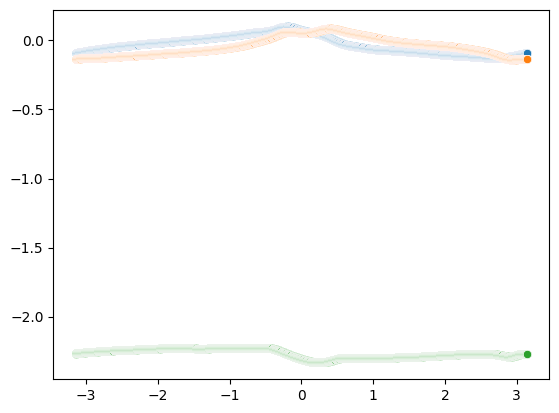

In [166]:
sns.scatterplot(x=theta_recon, y=coord_3d_recon[:,0])
sns.scatterplot(x=theta_recon, y=coord_3d_recon[:,1])
sns.scatterplot(x=theta_recon, y=coord_3d_recon[:,2])

In [167]:
# FILE_PATH_COORD_RECON = "../data/Bspline_202311/leaf_lobed_nIntervals_64.csv"
# FILE_PATH_COEF = "../data/Bspline_202311/leaf_lobed_coef_nIntervals_64.csv"

FILE_PATH_COORD_RECON = "data/result/"+name+"_nIntervals_32.csv"
FILE_PATH_COEF = "data/result/"+name+"_coef_nIntervals_32.csv"

np.savetxt(FILE_PATH_COORD_RECON, coord_3d_recon)
pd.DataFrame(np.stack([popt_x, popt_y, popt_z],1), columns=["c_x", "c_y", "c_z"]).to_csv(FILE_PATH_COEF, index=False)

## 可視化

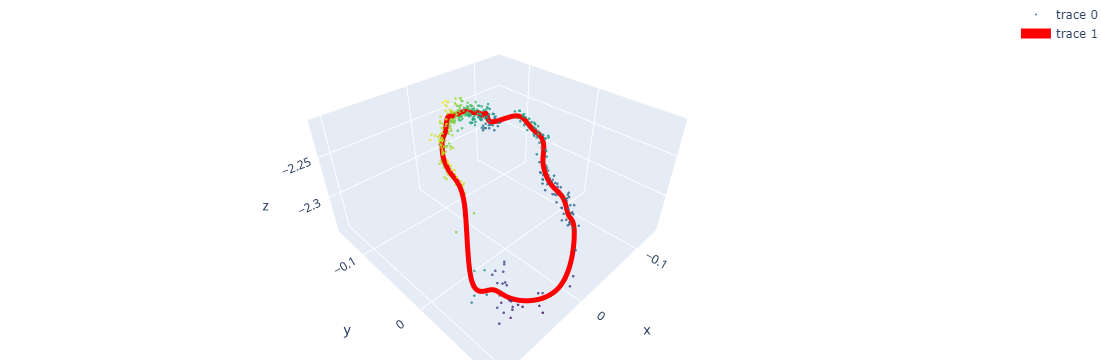

In [168]:
x,y,z = coord_3d[0:-1:100].T

x_recon,y_recon,z_recon = coord_3d_recon.T
x_recon = np.append(x_recon, x_recon[0])
y_recon = np.append(y_recon, y_recon[0])
z_recon = np.append(z_recon, z_recon[0])

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        color=z,                
        colorscale='Viridis',   
        opacity=0.8
    )
),go.Scatter3d(
    x=x_recon, y=y_recon, z=z_recon,
    marker=dict(
        size=1,
        colorscale='Viridis',
    ),
    line=dict(
        color="red",
        width=10
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), 
    scene={"aspectmode":"data"}
)

In [82]:
x_surf, y_surf, z_surf = vertices.T
I, J, K = triangles.T

fig = go.Figure(data=[
    go.Mesh3d(
            x=x_surf,
            y=y_surf,
            z=z_surf, 
            i=I, 
            j=J, 
            k=K, 
            color="lime",
            # flatshading=True,
            # colorscale=colorscale, 
            # intensity=z_surf, 
            opacity=0.7,
            showscale=False)
                     ])

fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False)
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), 
    scene={"aspectmode":"data"},
    scene_camera = dict(eye=dict(x=-3, y=-3, z=3)),
    plot_bgcolor = "rgba(0, 0, 0, 0)",
    paper_bgcolor = "rgba(0, 0, 0, 0)",
)
fig.show()
fig.write_image("data/result/"+name+".png", scale=6)

NameError: name 'vertices' is not defined

In [117]:
# curve_fragments[0][0]
len(curve_fragments[0])

25

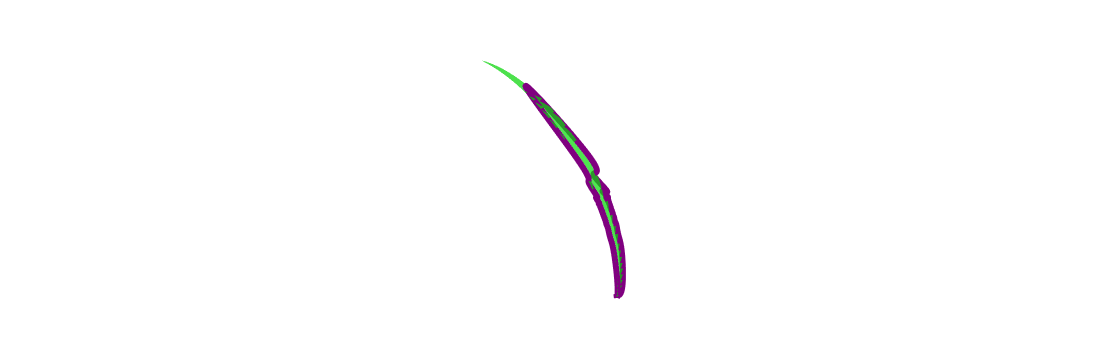

In [118]:
x_recon,y_recon,z_recon = coord_3d_recon.T
# x_recon = np.append(x_recon, x_recon[0])
# y_recon = np.append(y_recon, y_recon[0])
# z_recon = np.append(z_recon, z_recon[0])

x_surf, y_surf, z_surf = vertices.T
I, J, K = triangles.T

fig = go.Figure(data=[
    go.Mesh3d(
            x=x_surf,
            y=y_surf,
            z=z_surf, 
            i=I, 
            j=J, 
            k=K, 
            color="lime",
            # flatshading=True,
            # colorscale=colorscale, 
            # intensity=z_surf, 
            opacity=0.7,
            showscale=False),
    go.Scatter3d(
    x=x_recon,
    y=y_recon,
    z=z_recon,
    mode='lines',
    line=dict(
        width=12,
        color="purple",                
    )
)
                     ])

fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False)
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), 
    scene={"aspectmode":"data"},
    scene_camera = dict(eye=dict(x=-3, y=-3, z=3)),
    plot_bgcolor = "rgba(0, 0, 0, 0)",
    paper_bgcolor = "rgba(0, 0, 0, 0)",
)
fig.show()
fig.write_image("data/result/"+name+"_bspline.png", scale=6)

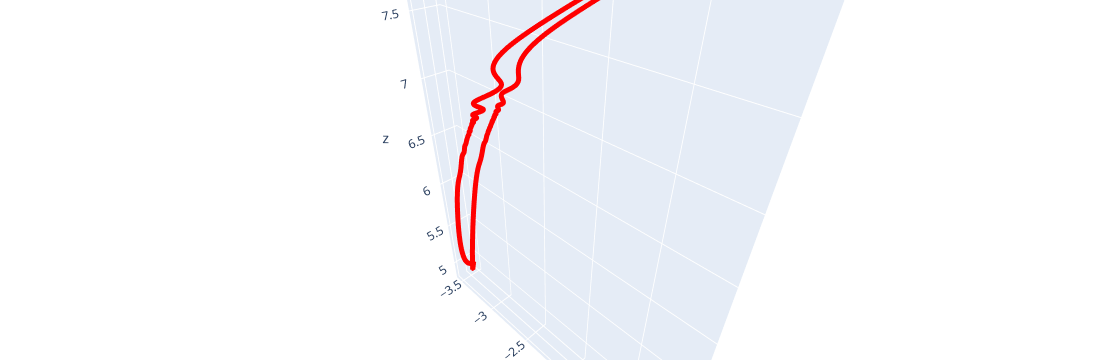

In [119]:
x,y,z = coord_3d_recon.T

fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    marker=dict(
        size=1,
        colorscale='Viridis',
    ),
    line=dict(
        color="red",
        width=10
    )
)
                     ])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), 
    scene={"aspectmode":"data"}
)

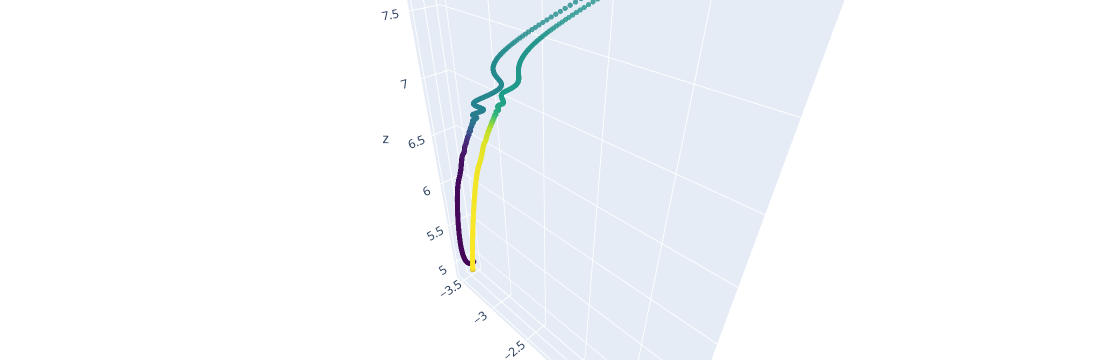

In [53]:
x,y,z = coord_3d_recon.T

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=theta_recon,                
        colorscale='Viridis',   
        opacity=0.8
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), 
    scene={"aspectmode":"data"}
)

## 差の計算
[Shapely](https://shapely.readthedocs.io/en/stable/)を使って，Fréchet距離を計算する

In [40]:
from shapely import linearrings, frechet_distance, hausdorff_distance

In [36]:
poly1 = linearrings(curve_list[0])
poly2 = linearrings(curve_list[1])

In [46]:
frechet_distance(poly1, poly2)

0.3119384263561945

In [47]:
frechet_distance(poly2, poly1)

0.3119384263561945

In [41]:
hausdorff_distance(poly1, poly2)

0.3328635115075736